# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [187]:
# import required libraries
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

## Support functions and variables

In [188]:
#!unzip ml-100k.zip -d .

In [189]:
MOVIELENS_DIR = "ml-100k"

In [190]:
!ls {MOVIELENS_DIR}

README       u.genre      u.user       u2.test      u4.test      ua.test
allbut.pl    u.info       u1.base      u3.base      u5.base      ub.base
mku.sh       u.item       u1.test      u3.test      u5.test      ub.test
u.data       u.occupation u2.base      u4.base      ua.base


In [191]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [192]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [193]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


In [194]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Q1

### (a)

In [195]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    ratingDF = rating_df.iloc[:,0:3]
    matrix = np.zeros((num_users,num_items),dtype=np.int8)
    
    for (index, userID, itemID, rating) in ratingDF.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    ###########         end         ###########
    return matrix

In [196]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [197]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
            # Extract the items the user already rated
                userVector = train_matrix[user, :]
                ratedItems = userVector[userVector.nonzero()]
            
                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg


        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
    
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            predictionMatrix[user, item] = itemPopularity[item]
                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [198]:
popularity_recsys = BaseLineRecSys('popularity')

In [199]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

In [200]:
x = popularity_recsys.getModel()

In [201]:
np.all(x<=1)

True

In [202]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [203]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:44, 2240.23it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [204]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [205]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [206]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [207]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:54, 1845.27it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)

In [208]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = pairwise_distances(matrix, metric='euclidean')
        similarity_matrix = 1/(1+similarity_matrix)
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = abs(1- pairwise_distances(matrix, metric='correlation'))
        
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
    
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            ###########         end         ###########

        elif self.base == 'item':
            ########### your code goes here ###########
            train_matrix = train_matrix.transpose()
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            normalizer = np.matmul(ii_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
    
            itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.transpose()
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [209]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [210]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [211]:
SimBasedRecSys.somethingelse(I)

array([[1. , 0.5, 0.5],
       [0.5, 1. , 0.5],
       [0.5, 0.5, 1. ]])

### (b)

Correlation. Both euclidean and cosine methods are distance based. The correlation measures how correlated two vectors are and furthermore, correlation score is also between -1 and 1. 

## Q3

### (a)

In [212]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [213]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [214]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [215]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [216]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:43, 2274.79it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [217]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

item_cosine_recsys.predict_all(rating_df, num_users, num_items)

item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

### (b)

In [218]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items) # obtain prediction matrix
                prediction = algorithm.evaluate_test(fold[1]) # append prediction to testDF
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [219]:
# How to use CrossValidation Class?

In [220]:
# 1. gather your algorithms in previous steps.
# algorithm_instances = [popularity_recsys, 
#                        average_user_rating_recsys, 
#                        user_cosine_recsys]

algorithm_instances = [user_cosine_recsys, item_cosine_recsys]

In [221]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_patk = CrossValidation('RMSE')

In [222]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


20000it [00:07, 2844.17it/s]
20000it [00:07, 2853.22it/s]
20000it [00:06, 2952.35it/s]
20000it [00:06, 2924.56it/s]
20000it [00:06, 2933.72it/s]


Processing algorithm item-cosine


20000it [00:06, 2944.12it/s]
20000it [00:07, 2734.43it/s]
20000it [00:07, 2667.48it/s]
20000it [00:07, 2747.42it/s]
20000it [00:06, 2897.72it/s]


{'user-cosine': [[1.0264490128856898,
   1.0214387664092763,
   1.0132940323507253,
   1.009400399702741,
   1.0161883960008826],
  1.017354121469863,
  1.0090130800118484,
  1.0256951629278774],
 'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226]}

The user-user similarity based moethod (RSME=1.017) is a little better than item-item similarity based (RSME=1.020). It might be due to that the rating per user rate is higher than the rating per item, meaning that there are more zeros (code start) itemwise. 

## Q4

### (a)

In [223]:
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys]

In [224]:
eval_metrics = ['RMSE','P@K','R@K']

In [225]:
results_list = []
for em in eval_metrics:
    
    cv_patk = CrossValidation(em)
    result = cv_patk.run(algorithm_instances, num_users, num_items,k=5)
    results_list.append(result)

Processing algorithm popularity


20000it [00:07, 2714.76it/s]
20000it [00:06, 2933.39it/s]
20000it [00:06, 2945.70it/s]
20000it [00:06, 2934.75it/s]
20000it [00:06, 2967.90it/s]


Processing algorithm useraverage


20000it [00:06, 2888.71it/s]
20000it [00:06, 2929.90it/s]
20000it [00:06, 2922.42it/s]
20000it [00:06, 2935.67it/s]
20000it [00:06, 2921.35it/s]
0it [00:00, ?it/s]

Processing algorithm user-cosine


20000it [00:07, 2834.38it/s]
20000it [00:07, 2776.71it/s]
20000it [00:07, 2712.96it/s]
20000it [00:06, 2890.32it/s]
20000it [00:07, 2817.58it/s]


Processing algorithm item-cosine


20000it [00:06, 2887.69it/s]
20000it [00:06, 2945.86it/s]
20000it [00:06, 2930.28it/s]
20000it [00:06, 2864.18it/s]
20000it [00:07, 2797.46it/s]


Processing algorithm popularity


20000it [00:08, 2494.13it/s]
20000it [00:06, 2983.10it/s]
20000it [00:06, 3072.23it/s]
20000it [00:06, 3081.27it/s]
20000it [00:07, 2708.97it/s]


Processing algorithm useraverage


20000it [00:06, 2904.92it/s]
20000it [00:06, 2873.86it/s]
20000it [00:07, 2573.17it/s]
20000it [00:07, 2706.81it/s]
20000it [00:06, 2899.15it/s]
0it [00:00, ?it/s]

Processing algorithm user-cosine


20000it [00:07, 2744.78it/s]
20000it [00:06, 2923.40it/s]
20000it [00:06, 3046.03it/s]
20000it [00:06, 3052.52it/s]
20000it [00:06, 3059.18it/s]


Processing algorithm item-cosine


20000it [00:06, 3063.69it/s]
20000it [00:06, 3078.95it/s]
20000it [00:07, 2787.89it/s]
20000it [00:06, 2858.24it/s]
20000it [00:07, 2613.53it/s]


Processing algorithm popularity


20000it [00:07, 2640.42it/s]
20000it [00:06, 2879.96it/s]
20000it [00:07, 2656.70it/s]
20000it [00:06, 2925.97it/s]
20000it [00:06, 2959.85it/s]


Processing algorithm useraverage


20000it [00:06, 2954.33it/s]
20000it [00:06, 2913.50it/s]
20000it [00:07, 2846.77it/s]
20000it [00:06, 3006.57it/s]
20000it [00:07, 2703.09it/s]
0it [00:00, ?it/s]

Processing algorithm user-cosine


20000it [00:07, 2739.76it/s]
20000it [00:06, 2942.05it/s]
20000it [00:06, 2931.87it/s]
20000it [00:06, 2946.92it/s]
20000it [00:07, 2798.43it/s]


Processing algorithm item-cosine


20000it [00:06, 2872.34it/s]
20000it [00:07, 2680.27it/s]
20000it [00:06, 2880.76it/s]
20000it [00:06, 2911.92it/s]
20000it [00:06, 2913.98it/s]


In [226]:
method_list = list(results_list[0].keys())

result_array = []
for i,method in enumerate(method_list):
    sub_list = []
    for j in range(len(eval_metrics)):
        sub_list.append(round(results_list[j][method][1],5))
    result_array.append([method]+sub_list)

In [227]:
endstring = '\n'+63*'-'+'\n'
header_str = [11*' '] + eval_metrics
method_list = list(results_list[0].keys())
print('\t\t'.join(h for h in header_str), end=endstring)
for r in result_array:
    print('\t\t'.join(str(e) for e in r))

           		RMSE		P@K		R@K
---------------------------------------------------------------
popularity		3.15909		0.55058		0.48408
useraverage		1.04372		0.47364		0.44132
user-cosine		1.01735		0.55584		0.48627
item-cosine		1.02008		0.53222		0.47497


### (b)

average_user_rating can't use p@k and r@k because it will have the same score for every movie not seen (average), therefore ranking is useless. RMSE cannot be used on popularity as it is not personalized. All metrics can be used for collab filtering methods, but ranking are more useful than rmlse. This can be seen in the results above.

### (c)

RMSE: user-cosine 1.017 (average rating close)
P@K: user-cosine 0.56 (popularity close)
R@k: user-cosine 0.49 (popularity close)

User-cosine performed the best in all metrics. This is because it is trying to tailor and rank unseen movies based on the similarity to other users that share similar behaviour. It makes sense that for RMSE average rating came in close second as this would reduce the error the most and popularity for ranking metrics as people tend to all like popular movies.

### (d)

Good RMSE indicate better generalization of the learned model and often better ranking. However, it is not vice-versa, meaning that good performance on ranking does not necessarily mean perfect RMSE. Ranking focuses more on high-scoring items whereas RMSE places equal emphasis on high and low ratings.

## Q5

### (a)

In [228]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [229]:
movie2choose = ['Four Weddings and a Funeral (1994)',
                'Reservoir Dogs (1992)',
                '12 Angry Men (1957)']

In [230]:
matrix = dataPreprocessor(rating_df, num_users, num_items)
# item-item
matrix = matrix.transpose()
#find similarity 
similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')

In [231]:
movie_names = moviesDF.movieTitle.values
movieSimDF = pd.DataFrame(data=similarity_matrix,columns=movie_names,index=movie_names)

In [232]:
movieSimDF.head()

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
Toy Story (1995),1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
GoldenEye (1995),0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
Four Rooms (1995),0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
Get Shorty (1995),0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
Copycat (1995),0.286714,0.318836,0.212957,0.334239,1.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


In [233]:
for m in movie2choose:
    print('Top 5 most similar movies to {0} are:'.format(m))
    print(66*'-')
    print(movieSimDF[m].nlargest(6)[1:])
    print('\n')

Top 5 most similar movies to Four Weddings and a Funeral (1994) are:
------------------------------------------------------------------
When Harry Met Sally... (1989)               0.653888
Back to the Future (1985)                    0.634407
Forrest Gump (1994)                          0.592537
Indiana Jones and the Last Crusade (1989)    0.591821
Dances with Wolves (1990)                    0.589076
Name: Four Weddings and a Funeral (1994), dtype: float64


Top 5 most similar movies to Reservoir Dogs (1992) are:
------------------------------------------------------------------
Pulp Fiction (1994)                 0.593023
Usual Suspects, The (1995)          0.579705
Seven (Se7en) (1995)                0.540307
Die Hard (1988)                     0.531539
Silence of the Lambs, The (1991)    0.523178
Name: Reservoir Dogs (1992), dtype: float64


Top 5 most similar movies to 12 Angry Men (1957) are:
------------------------------------------------------------------
Bridge on the River 

### (b)

For the first movie I chose ('Four Weddings and a Funeral (1994)'), it seems that the top 3 recommendations make sense. 'Four Weddings and a Funeral (1994)' is a comedy telling some funny and absurd stories. However, the 4th and 5th doesn't really seem to be similar based on their realm. 
The recommendations for the second movie ('Reservoir Dogs (1992)') seem to be working quite well. It is a movie telling stories about gangs and cops with a sense of humor directed by Quentin Taratino. The first recommendation 'Pulp Fiction (1994)' is almost the same type of movie which is even directed by the same director. All the other 4 recommendations are movies about crimes and violence and hence similar.
The recommendations for '12 Angry Men (1957)' are not doing a very good job except that all the recommended movies are around the same time. It's possibly due to that this movie is not rated by many users or because users like this movies tend to like old movies of any type, making it hard for the system to make recommendations. 

## Q6 [GRAD ONLY]

### (a)

### count # of ratings

In [234]:
class CrossValidation_NEW(object):
    def __init__(self, metric, trainset, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(data_path,trainset)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    # modified version
    @staticmethod
    def _getData(data_path,trainset):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = trainset # mannually input the trainset (subset of the original training set)
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items) # obtain prediction matrix
                prediction = algorithm.evaluate_test(fold[1]) # append prediction to testDF
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [235]:
rating_per_userDF = rating_df.groupby('userID').count().reset_index()

In [236]:
rating_per_userDF.drop('itemID',axis=1,inplace=True)
rating_per_userDF.drop('timestamp',axis=1,inplace=True)

In [237]:
rating_per_userDF.head()

,userID,rating
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175


Text(0, 0.5, 'Number of users')

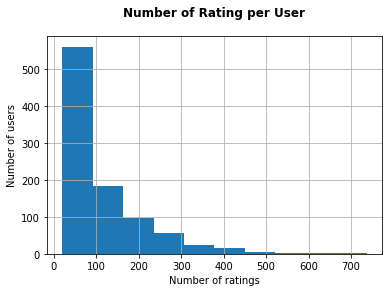

In [238]:
rating_per_userDF['rating'].hist()
plt.title('Number of Rating per User',fontweight='bold',pad=20)
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')

In [239]:
threshold = 150

### generate two new sub dataframes, one above threshold, one below

In [240]:
ratingDF_aboveT = rating_df[rating_df['userID'].isin(rating_per_userDF[rating_per_userDF['rating']>=threshold].userID.tolist())]

In [241]:
ratingDF_belowT = rating_df[rating_df['userID'].isin(rating_per_userDF[rating_per_userDF['rating']<threshold].userID.tolist())]

### user-user and item-item for samples above threshold

In [242]:
user_cosine_recsys_aboveT = SimBasedRecSys('user','cosine')
user_cosine_recsys_aboveT.predict_all(ratingDF_aboveT, num_users, num_items)
user_cosine_recsys_aboveT.getModel()

array([[3.90828212, 3.17845741, 3.04770446, ..., 3.61029398, 3.        ,
        3.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.92314263, 3.24337225, 3.09622532, ..., 3.41071408, 3.        ,
        3.        ]])

In [257]:
uuDF_aboveT = user_cosine_recsys_aboveT.evaluate_test(ratingDF_aboveT,copy=True)

58071it [00:22, 2484.41it/s]


In [258]:
uuDF_aboveT.head()

,userID,itemID,rating,timestamp,user-cosine
3,244,51,2,880606923,3.405149
8,305,451,3,886324817,3.348650
9,6,86,3,883603013,3.966463
10,62,257,2,879372434,3.670091
11,286,1014,5,879781125,3.160594


In [244]:
item_cosine_recsys_aboveT = SimBasedRecSys('item','cosine')
item_cosine_recsys_aboveT.predict_all(ratingDF_aboveT, num_users, num_items)
item_cosine_recsys_aboveT.getModel()

array([[3.73506133, 3.66469554, 3.72689041, ..., 0.        , 3.81107983,
        3.91871281],
       [3.90502771, 3.20999968, 3.01666616, ..., 0.        , 2.99997   ,
        2.99997   ],
       [3.90502771, 3.20999968, 3.01666616, ..., 0.        , 2.99997   ,
        2.99997   ],
       ...,
       [3.90502771, 3.20999968, 3.01666616, ..., 0.        , 2.99997   ,
        2.99997   ],
       [3.90502771, 3.20999968, 3.01666616, ..., 0.        , 2.99997   ,
        2.99997   ],
       [3.50428995, 3.48197827, 3.54035123, ..., 0.        , 3.64523202,
        3.61728168]])

In [259]:
iiDF_aboveT = item_cosine_recsys_aboveT.evaluate_test(ratingDF_aboveT,copy=True)

58071it [00:23, 2474.02it/s]


In [260]:
iiDF_aboveT.head()

,userID,itemID,rating,timestamp,item-cosine
3,244,51,2,880606923,3.652776
8,305,451,3,886324817,3.366407
9,6,86,3,883603013,3.767798
10,62,257,2,879372434,3.376898
11,286,1014,5,879781125,3.721569


### user-user and item-item for samples below threshold

In [248]:
user_cosine_recsys_belowT = SimBasedRecSys('user','cosine')
user_cosine_recsys_belowT.predict_all(ratingDF_belowT, num_users, num_items)
user_cosine_recsys_belowT.getModel()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.83359179, 3.1765445 , 2.96620958, ..., 2.        , 3.70967682,
        3.70967682],
       [3.87720486, 3.06103327, 3.13544493, ..., 2.        , 2.79629578,
        2.79629578],
       ...,
       [3.89709251, 3.22458037, 3.13061426, ..., 2.        , 4.04545271,
        4.04545271],
       [3.9125327 , 3.19773862, 2.97866969, ..., 2.        , 4.26582224,
        4.26582224],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [261]:
uuDF_belowT = user_cosine_recsys_belowT.evaluate_test(ratingDF_belowT,copy=True)

41929it [00:16, 2547.40it/s]


In [262]:
uuDF_belowT.head()

,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.076216
1,186,302,3,891717742,4.137425
2,22,377,1,878887116,1.567505
4,166,346,1,886397596,3.478010
5,298,474,4,884182806,4.276963


In [250]:
item_cosine_recsys_belowT = SimBasedRecSys('item','cosine')
item_cosine_recsys_belowT.predict_all(ratingDF_belowT, num_users, num_items)
item_cosine_recsys_belowT.getModel()

array([[3.86080572, 3.19354736, 3.06666564, ..., 1.99998   , 0.        ,
        0.        ],
       [3.84849471, 3.88452839, 3.79306174, ..., 3.73377959, 0.        ,
        0.        ],
       [2.83282908, 3.0524709 , 2.78232051, ..., 2.98953784, 0.        ,
        0.        ],
       ...,
       [4.1356925 , 4.14193519, 4.02357764, ..., 4.        , 0.        ,
        0.        ],
       [4.36618946, 4.44743828, 4.21901844, ..., 3.95562418, 0.        ,
        0.        ],
       [3.86080572, 3.19354736, 3.06666564, ..., 1.99998   , 0.        ,
        0.        ]])

In [263]:
iiDF_belowT = item_cosine_recsys_belowT.evaluate_test(ratingDF_belowT,copy=True)

41929it [00:16, 2605.85it/s]


In [264]:
iiDF_belowT.head()

,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.614681
1,186,302,3,891717742,3.426588
2,22,377,1,878887116,2.911779
4,166,346,1,886397596,3.261389
5,298,474,4,884182806,4.166895


### results

In [303]:
df_list = [uuDF_aboveT, uuDF_belowT, iiDF_aboveT, iiDF_belowT]
ui_list = ['user-user','user_user','item-item','item-item']
th_list = ['below threshold', 'above threshold']*2

In [304]:
endstring = '\n'+75*'-'+'\n'

In [305]:
for i, df in enumerate(df_list):
    pred = df.iloc[:,-1]
    rating = df.loc[:]['rating']
    rsme = sqrt(mean_squared_error(pred, rating))
    print('The RSME of {0} based method {1} is: {2}'.format(ui_list[i], th_list[i], rsme), end=endstring)

The RSME of user-user based method below threshold is: 0.9477287274687372
---------------------------------------------------------------------------
The RSME of user_user based method above threshold is: 0.9689025634978259
---------------------------------------------------------------------------
The RSME of item-item based method below threshold is: 0.9886944724462904
---------------------------------------------------------------------------
The RSME of item-item based method above threshold is: 0.9539724923034288
---------------------------------------------------------------------------


For user-user based method, the subset below the threshold performs better since more users are below the threshold. For item-item based method, the subset above the threshold performs better since there are more ratings. 

# Validation

In [254]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [255]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [277]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [278]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [281]:
validatePopularityRecSys()

### User Average Based Recommendation

In [282]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('average_user_rating')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [285]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [286]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [287]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [288]:
validateCustomizedSim()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


### User-User Similarity Based Recommendation System

In [289]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [290]:
validateUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [291]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [292]:
validateIISimBasedRecSys()